【問題2】初期化方法のクラス化

In [1]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
    n_nodes1:
    n_nodes2:
    ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
        後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)[np.newaxis, :]
        
        return B

In [2]:
class Xavier:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W_xavi = self.sigma * np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)
        
        return W_xavi
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn (n_nodes2)[np.newaxis, :]
    
        return B

In [3]:
class He:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W_he = self.sigma * np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)*np.sqrt(2)
        
        return W_he
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn (n_nodes2)[np.newaxis, :]
        
        return B

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        
        return layer

【問題7】最適化手法

In [5]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        self.h = 1e-7
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.h += layer.dW*layer.dW
        layer.W -= self.lr*layer.dW/np.sqrt(self.h)
        layer.B -= self.lr * layer.dB
        
        return layer

【問題4】活性化関数のクラス化

【問題5】ReLUクラスの作成

In [6]:
class Sigmoid:
    """
    sigmoid関数の処理と導関数の算出
    """
    
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A  = A
        Z = 1/1+np.exp(-self.A)
        
        return Z
    
    def backward(self, dout):
        Z = self.forward(self.A)
        dout_sig = Z*(1-Z)*dout
        
        return dout_sig
    
class Tanh:
    """
    tanh関数の処理と導関数の算出
    """
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = (np.exp(self.A)-np.exp(-self.A)) / (np.exp(self.A)+np.exp(-self.A))
        
        return Z
    
    def backward(self, dout):
        Z = self.forward(self.A)
        dout_tanh = (1-Z**2)*dout
        
        return dout_tanh
    
class Relu:
    """
    relu関数の処理と導関数の算出
    """
    
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = np.where(self.A<=0, 0, self.A)
        
        return Z
    
    def backward(self, dout):
        dout_relu = np.where(self.A<=0, 0, 1)*dout
        
        return dout_relu
    
class Softmax:
    """
    relu関数の処理とsoftmax_with_cross_entropyの導関数の算出
    """
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        #if A.ndim == 2:
           # A = A.T
           # A = A - np.max(A, axis=0)
           # y = np.exp(A) / np.sum(np.exp(A), axis=0)
           # return y.T
        A = A - np.max(A)
        Z = np.exp(A) / np.sum(np.exp(A),axis=1, keepdims=True)
        self.Z = Z
        
        return Z
    
    
    def backward(self, y):
        dout_soft_max = self.Z - y
        
        return dout_soft_max

In [7]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [8]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        # XとWの内積をとり、biasを加える
        self.Z = copy.deepcopy(X) # Xが更新されないように
        A = np.dot(X, self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 勾配を算出する
        self.dB = np.average(dA)
        self.dW = np.dot(self.Z.T, dA)/dA.shape[0]
        
        dZ = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self)# FCクラスのself.W, self.B, self.dW, self.dBを用いて更新
        
        return dZ


In [9]:
class Dropout:
    """
    randomに生成したWと同じ配列の要素でdroput_ratioを以下のものをFalseとして格納
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, X, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_ratio # *X.shapeはXと同じshapeにするため
            return X*self.mask
        
        else:
            return X*(1-self.dropout_ratio)
        
    def backward(self, dout):
        
        return dout * self.mask

In [10]:
class Loss:
    
    def __init__(self):
        pass
        
    def cross_entropy_error(self, y_pred, y):
        cross_entropy_error = np.sum(-1*y*np.log(y_pred+1e-10),axis=1)
        
        return cross_entropy_error

In [39]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    FCでインスタンスを作り、Activationで活性化関数を通したものをaddで追加指定いく
    """
    def __init__(self, epoch, batch_size):
        self.epoch = epoch
        self.batch_size = batch_size
        self.losses = []
        self.val_losses=[]
        self.layers = []
        
    def add(self, layer):
        self.layers += [layer] # model.add(インスタンスで層を追加)
    
    def forward_layer(self, X):
        for layer in self.layers:
            X = layer.forward(X)
            
        return X
    
    def backward_layer(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
        return y
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        
        for i in range(self.epoch):
            print('-----------------')
            print('epoch{}回目の学習'.format(i+1))
            get_mini_batch = GetMiniBatch(X, y, self.batch_size, seed=10)
            #if X_val is not None and y_val is not None:
            
            # minibatchのイテレーション
            for mini_X_train, mini_y_train in get_mini_batch:
                #イテレーションごとのフォワード
                Z3 = self.forward_layer(mini_X_train) # 使わない

                #イテレーションごとのバックワード
                dX = self.backward_layer(mini_y_train)# 使わない
                
            loss = Loss()
            Z3_train = self.forward_layer(X_train)
            epoch_train_loss = np.sum(loss.cross_entropy_error(Z3_train, y_train))/len(y_train) # 最後の重みでエポックlossを算出
            self.losses += [epoch_train_loss]
            print('epoch_train_loss{}'.format(epoch_train_loss))
            
            if np.any(X_val):
                val_loss = Loss()
                Z3_val = self.forward_layer(X_val)
                epoch_val_loss = np.sum(loss.cross_entropy_error(Z3_val, y_val))/len(y_val) # val_lossもtrain
                self.val_losses += [epoch_val_loss] 
                print(('epoch_val_loss{}'.format(epoch_val_loss)))
                
                
    def predict(self, X_test):
        X = X_test
        for layer in self.layers:
            X = layer.forward(X)
        
        y_pred = np.argmax(X, axis=1)
        
        return y_pred
    
    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred==y_test)/len(y_test)
        
        return accuracy


In [40]:
import numpy as np
from keras.datasets import mnist
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [41]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [42]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [43]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [45]:
three_layers = ScratchDeepNeuralNetrowkClassifier(100, 100)
three_layers.add(FC(784, 400, SimpleInitializer(sigma=0.01), AdaGrad(0.001)))
three_layers.add(Dropout(0.2))
three_layers.add(Relu())
three_layers.add(FC(400, 200, SimpleInitializer(sigma=0.01), AdaGrad(0.001)))
three_layers.add(Dropout(0.2))
three_layers.add(Relu())
three_layers.add(FC(200, 10, SimpleInitializer(sigma=0.01), AdaGrad(0.001)))
three_layers.add(Softmax())

three_layers.fit(X_train, y_train, X_val, y_val)

-----------------
epoch1回目の学習
epoch_train_loss0.678969333576132
epoch_val_loss0.689286531387925
-----------------
epoch2回目の学習
epoch_train_loss0.5576906785577821
epoch_val_loss0.5702645812074432
-----------------
epoch3回目の学習
epoch_train_loss0.5042890570769111
epoch_val_loss0.5177322624261252
-----------------
epoch4回目の学習
epoch_train_loss0.47317402750217774
epoch_val_loss0.48715649887755913
-----------------
epoch5回目の学習
epoch_train_loss0.45169273414080247
epoch_val_loss0.4661428139103053
-----------------
epoch6回目の学習
epoch_train_loss0.4353758347801003
epoch_val_loss0.4502894944591336
-----------------
epoch7回目の学習
epoch_train_loss0.4222185564010224
epoch_val_loss0.43756845392209165
-----------------
epoch8回目の学習
epoch_train_loss0.4112045654981743
epoch_val_loss0.4269371943145734
-----------------
epoch9回目の学習
epoch_train_loss0.40172653824485344
epoch_val_loss0.41779967433805487
-----------------
epoch10回目の学習
epoch_train_loss0.39339795448677317
epoch_val_loss0.4097906662753391
--------------

epoch_train_loss0.23568181017906545
epoch_val_loss0.25836077913016164
-----------------
epoch84回目の学習
epoch_train_loss0.23473399129443442
epoch_val_loss0.25746072517688806
-----------------
epoch85回目の学習
epoch_train_loss0.23379717245746215
epoch_val_loss0.25657478235909503
-----------------
epoch86回目の学習
epoch_train_loss0.23287332211899078
epoch_val_loss0.2557000848606474
-----------------
epoch87回目の学習
epoch_train_loss0.23196025953184493
epoch_val_loss0.2548399764227345
-----------------
epoch88回目の学習
epoch_train_loss0.23105847647468336
epoch_val_loss0.2539896690299378
-----------------
epoch89回目の学習
epoch_train_loss0.23016545858156742
epoch_val_loss0.2531479200586187
-----------------
epoch90回目の学習
epoch_train_loss0.22928282076067855
epoch_val_loss0.252317881967536
-----------------
epoch91回目の学習
epoch_train_loss0.22840917173799266
epoch_val_loss0.25149283067870715
-----------------
epoch92回目の学習
epoch_train_loss0.2275450873297576
epoch_val_loss0.25067992720586546
-----------------
epoch93回目の

【問題2】学習曲線のプロット

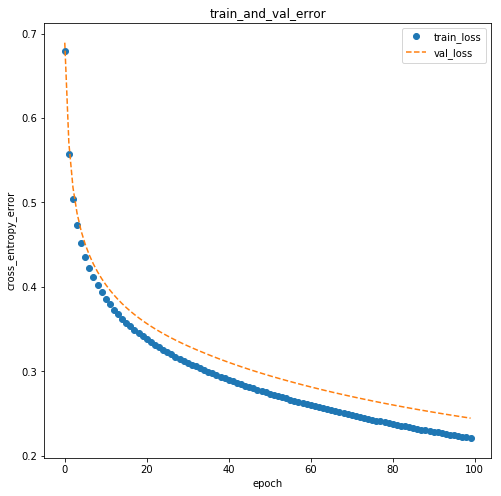

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(three_layers.losses, 'o', label='train_loss')
plt.plot(three_layers.val_losses, '--', label='val_loss')
plt.title('train_and_val_error')
plt.xlabel('epoch')
plt.ylabel('cross_entropy_error')
plt.legend()
plt.show()

In [51]:
three_layers.predict(X_test)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [52]:
three_layers.accuracy(X_test, y_test)

0.9332